In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt
%matplotlib widget

In [2]:
import os
import sys
from pathlib import Path

src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [3]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
import config
import pickle
from ray import tune
import matplotlib.pyplot as plt
from inspect import signature
from tqdm.notebook import tqdm
import pandas

load the gray-matter, and blood-vessel pathlengths and scattering counts

In [4]:
gray_matter_mcs_pathlength_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_pathlength_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
tumor_mcs_pathlength_data = np.loadtxt(config.pl_dir / "tumor_mcs.txt")

create MCS-Attenuation Object

In [5]:
A_mcs = SimulationAttenuation(config.mcs_func_path)

Loaded data with 50000.0 photons and 30 values for mu_s.


load the m-parameters for the Jacques models

In [6]:
with open(config.m_params_path, "rb") as f:
    jacques_m_params, _, _, _ = pickle.load(f)

In [7]:
jacques_m_params

{'gray matter': array([7.36235175, 0.07880996, 1.82036491]),
 'blood vessel': array([ 26327.23900903, -26318.31894318,  28718.23874622]),
 'tumor': array([6.69629536, 0.73994694, 4.47359248]),
 'general': array([8.17504229, 0.01010447, 1.44170499])}

# Forward Test

- Input tissue concentrations, and reconstruct spectra with every model
- compute squared average (over wavelength range) attenuation error per tissue and model

In [8]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

Interpolate path and scatter lengths for MBLL + MCS

In [9]:
lengths = tuple()
for mcs_data in (gray_matter_mcs_pathlength_data, tumor_mcs_pathlength_data, blood_vessel_mcs_pathlength_data):
    pathlength = np.interp(wavelengths, mcs_data[:, 0], mcs_data[:, 4] / 10) # convert to cm
    # notice the minus: mean scatterlength = mean pathlength - ((mean scattercount)/mu_s)
    scatterlength = mcs_data[:, 4] / 10 - mcs_data[:, 5] / (mcs_data[:, 2] * 10)
    scatterlength = np.interp(wavelengths, mcs_data[:, 0], scatterlength)
    lengths += (pathlength, scatterlength)

gray_matter_pathlength, gray_matter_scatterlength, tumor_pathlength, tumor_scatterlength, blood_vessel_pathlength, blood_vessel_scatterlength = lengths

In [10]:
#gray_matter_baseline_attenuation = np.interp(
#    wavelengths,
#    gray_matter_mcs_pathlength_data[:, 0],
#    -np.log(gray_matter_mcs_pathlength_data[:, 3])
#)

# take baseline attenuation from simulation data
# this avoids small error due to interpolation
# this small interpolation error causes large errors in concentration reconstruction for MBLL
# Otherwise, when reconstructing concentr. for baseline attenuation, we will not get baseline concentrations

gray_matter_baseline_attenuation = simulation_data["gray matter"][-1][:, 0]

# for blood vessel average, there is no simulation data
blood_vessel_baseline_attenuation = np.interp(
    wavelengths,
    blood_vessel_mcs_pathlength_data[:, 0],
    -np.log(blood_vessel_mcs_pathlength_data[:, 3])
)

tumor_baseline_attenuation = simulation_data["tumor"][-1][:, 0]


To test the MBLL with wavelength-independent PL, the average path- and scatter-lengths are computed

all models and their tissue-specific inputs

In [11]:
tissue_types = ["gray matter", "artery", "vein", "tumor"]
gray_matter_params = {
    "baseline_attenuation": gray_matter_baseline_attenuation,
    "baseline_c": data_loader.DataLoader.tissue_parameters["gray matter"][0],
    "baseline_a": data_loader.DataLoader.tissue_parameters["gray matter"][1][0],
    "baseline_b": data_loader.DataLoader.tissue_parameters["gray matter"][1][1],
    "pathlength": gray_matter_pathlength,
    "scatterlength": gray_matter_scatterlength,
    "g": data_loader.DataLoader.tissue_parameters["gray matter"][2]
}
blood_vessel_params = {
    "baseline_attenuation": blood_vessel_baseline_attenuation,
    "baseline_c": data_loader.DataLoader.tissue_parameters["blood vessel"][0],
    "baseline_a": data_loader.DataLoader.tissue_parameters["blood vessel"][1][0],
    "baseline_b": data_loader.DataLoader.tissue_parameters["blood vessel"][1][1],
    "pathlength": blood_vessel_pathlength,
    "scatterlength": blood_vessel_scatterlength,
    "g": data_loader.DataLoader.tissue_parameters["blood vessel"][2]
}
tumor_params = {
    "baseline_attenuation": tumor_baseline_attenuation,
    "baseline_c": data_loader.DataLoader.tissue_parameters["tumor"][0],
    "baseline_a": data_loader.DataLoader.tissue_parameters["tumor"][1][0],
    "baseline_b": data_loader.DataLoader.tissue_parameters["tumor"][1][1],
    "pathlength": tumor_pathlength,
    "scatterlength": tumor_scatterlength,
    "g": data_loader.DataLoader.tissue_parameters["tumor"][2]
}
gray_matter_params_constant_pl = gray_matter_params.copy()
gray_matter_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.ones(len(wavelengths))
)
blood_vessel_params_constant_pl = blood_vessel_params.copy()
blood_vessel_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.ones(len(wavelengths))
)
tumor_params_constant_pl = tumor_params.copy()
tumor_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.ones(len(wavelengths))
)

forward_models = {
    "MBLL MCS": (
        mbll_new,
        {
            "gray matter": gray_matter_params,
            "artery": blood_vessel_params,
            "vein": blood_vessel_params,
            "tumor": tumor_params
        }
    ),
    "MBLL const": (
        # mbll but with constant path- and scatterlengths
        mbll_new, 
        {
            "gray matter": gray_matter_params_constant_pl,
            "artery": blood_vessel_params_constant_pl,
            "vein": blood_vessel_params_constant_pl,
            "tumor": tumor_params_constant_pl
        }
    ),
    "Jacques, tissue specific": (
        # Jacques with tissue-specific m-parameters
        A_jacques_concentrations,
        {tissue_type : {f"m{i}" : jacques_m_params[(tissue_type if tissue_type not in {"artery", "vein"} else "blood vessel")][i-1] for i in range(1, 4)} for tissue_type in tissue_types},
    ),
    "Jacques, general": (# Jacques with general m-parameters
        A_jacques_concentrations,
        {tissue_type : {f"m{i}" : jacques_m_params["general"][i-1] for i in range(1, 4)} for tissue_type in tissue_types},          
    ),
    "MCS NLLS": (
        A_mcs.A_concentrations,
        {tissue_type: dict() for tissue_type in tissue_types},
    ),
    "Carp": (
        A_carp_concentrations,
        {tissue_type : {("g", "n")[i-2] : data_loader.DataLoader.tissue_parameters[tissue_type][i] for i in range(2, 4)} for tissue_type in tissue_types},
    ),
    "Patterson": (
        A_patterson_concentrations,
        {tissue_type : {"n" : data_loader.DataLoader.tissue_parameters[tissue_type][-1]} for tissue_type in tissue_types}
    )
}


In [12]:
#(model, tissue-type, num_spectra, wavelengths)
reconstructed_spectra = np.empty((len(forward_models), len(simulation_data.keys()), simulation_data["gray matter"][-1].shape[1], len(wavelengths)))

In [13]:
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [14]:
for model_idx, model_str in enumerate(forward_models.keys()):
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, params in enumerate(np.row_stack(simulation_data[tissue_type][:2]).T):
            A_reconstructed = forward_models[model_str][0](
                wavelengths,
                mu_a_matrix,
                params[:-2],
                *params[-2:],
                **forward_models[model_str][1][tissue_type]
            )
            reconstructed_spectra[model_idx, tissue_idx, spectrum_idx, :] = A_reconstructed[:, 0]

Plot reconstructed spectra

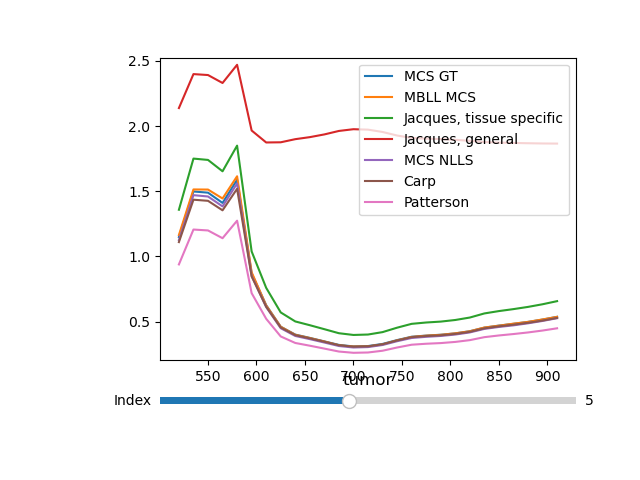

In [15]:
reconstructed_spectra_copy = reconstructed_spectra.copy()
model_mask = [True] * reconstructed_spectra.shape[0]
model_mask[1] = False
tissue_idx = 3
tissue_type = ["gray matter", "artery", "vein", "tumor"][tissue_idx]
plot_spectra_slider(
    np.concatenate(
        (
            simulation_data[tissue_type][2][None, ...],
            reconstructed_spectra[model_mask, tissue_idx, :, :].transpose(0, 2, 1)
        ),
        axis=0
    ),
    wavelengths,
    ["MCS GT"] + list(np.array(list(forward_models.keys()))[model_mask]),
    #["MCS GT", "jt", "jg", "mcs", "c", "p"],
    title=tissue_type
)

Store the results

Compute squared attenuation error

In [16]:
# models, tissue, spectrum
squared_attenuation_error = np.empty((len(forward_models), 4, simulation_data["tumor"][-1].shape[1]))
# models, tissue + 1
squared_attenuation_error_total_avg = np.empty((len(forward_models), 5))

for tissue_idx, tissue in enumerate(tissue_types):
    squared_attenuation_error[:, tissue_idx, :] = np.sqrt(np.sum((reconstructed_spectra[:, tissue_idx, :, :] - simulation_data[tissue][-1][:, :, None].T)**2, axis=-1))
    squared_attenuation_error_total_avg[:, tissue_idx] = np.average(squared_attenuation_error[:, tissue_idx, :], axis=-1)

squared_attenuation_error_total_avg[:, 4] = np.average(squared_attenuation_error_total_avg[:, :4], axis=-1)

In [17]:
df = pandas.DataFrame(squared_attenuation_error_total_avg)
df.index = list(forward_models.keys())
df.columns = ["gray matter", "artery", "vein", "tumor", "average"]
print(df)

                          gray matter      artery        vein       tumor  \
MBLL MCS                     0.118361    0.361709    0.401597    0.255978   
MBLL const                  69.065319  257.089195  348.479680  342.222033   
Jacques, tissue specific     3.318677    3.104409    3.600569    0.761197   
Jacques, general             6.077286    5.166065    5.162447    7.114564   
MCS NLLS                     0.112512    0.227732    0.239051    0.084496   
Carp                         0.271114    1.002164    1.138648    0.172213   
Patterson                    1.121972    4.110299    4.606434    0.824839   

                             average  
MBLL MCS                    0.284411  
MBLL const                254.214057  
Jacques, tissue specific    2.696213  
Jacques, general            5.880091  
MCS NLLS                    0.165948  
Carp                        0.646035  
Patterson                   2.665886  


# Backward Test

## Simulated Spectra

In [18]:
# (models, tissues, params)
num_params = simulation_data["gray matter"][0].shape[0] + simulation_data["gray matter"][1].shape[0]

In [19]:
# object for MBLL + MCS
A_mbll_fit_simulated_mcs = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    [gray_matter_pathlength, blood_vessel_pathlength, tumor_pathlength],
    [gray_matter_scatterlength, blood_vessel_scatterlength, tumor_scatterlength],
    [gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation],
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T,
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)


In [20]:
# diffusion + MBLL
# compute baseline attenuation, pathlength and scatterlength
baseline_attenuations_diffusion, baseline_pathlengths_diffusion, baseline_scatterlengths_diffusion = [], [], []
for tissue_type in ["gray matter", "blood vessel", "tumor"]:
    params = (
        wavelengths,
        mu_a_matrix,
        data_loader.DataLoader.tissue_parameters[tissue_type][0],
        *data_loader.DataLoader.tissue_parameters[tissue_type][1],
        *data_loader.DataLoader.tissue_parameters[tissue_type][-2:],
    )
    baseline_attenuations_diffusion.append(A_carp_concentrations(*params)[:, 0])
    baseline_pathlengths_diffusion.append(A_carp_pathlength(*params)[:, 0]),
    baseline_scatterlengths_diffusion.append(A_carp_scatterlength(*params)[:, 0])

A_mbll_fit_simulated_diffusion = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    baseline_pathlengths_diffusion,
    baseline_scatterlengths_diffusion,
    baseline_attenuations_diffusion,
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *(np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T),
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)


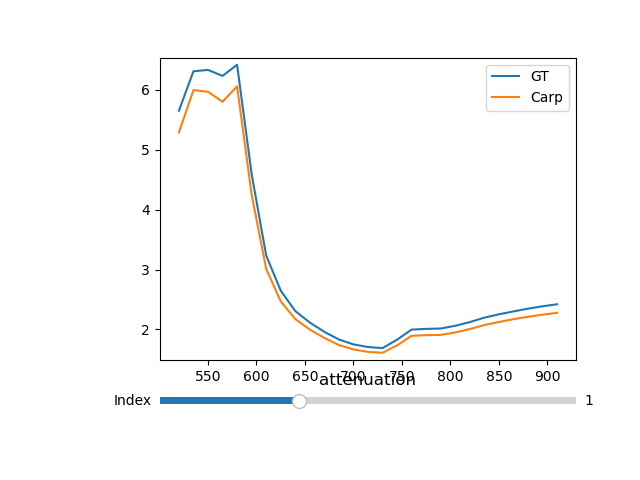

In [21]:
plot_spectra_slider(np.array([[gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation], baseline_attenuations_diffusion]).transpose(0, 2, 1), wavelengths, ["GT", "Carp"], title="attenuation")

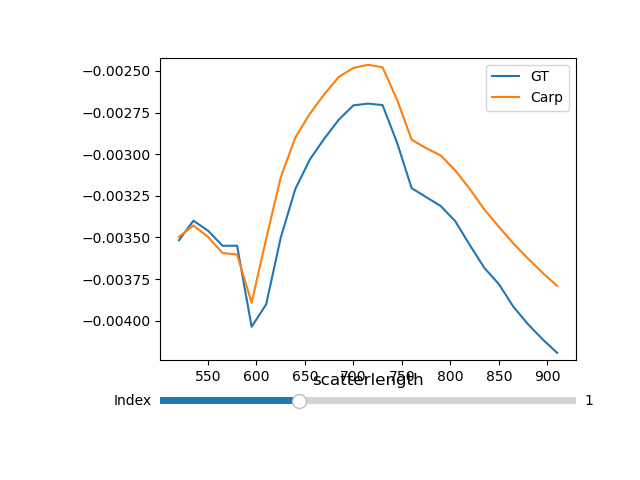

In [22]:
plot_spectra_slider(np.array([[gray_matter_scatterlength, blood_vessel_scatterlength, tumor_scatterlength], baseline_scatterlengths_diffusion]).transpose(0, 2, 1), wavelengths, ["GT", "Carp"], title="scatterlength")

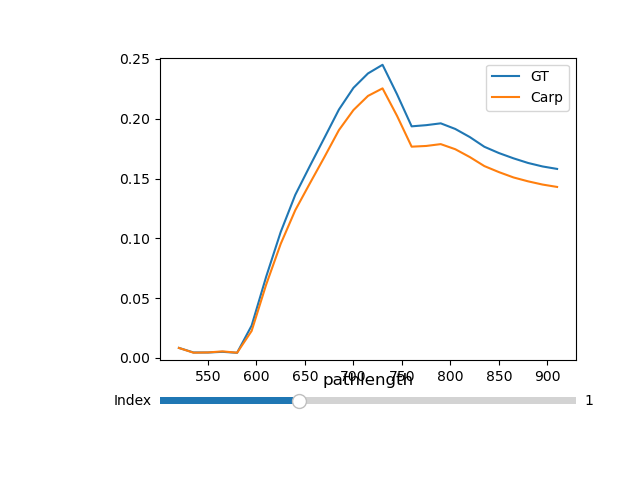

In [23]:
plot_spectra_slider(np.array([[gray_matter_pathlength, blood_vessel_pathlength, tumor_pathlength], baseline_pathlengths_diffusion]).transpose(0, 2, 1), wavelengths, ["GT", "Carp"], title="pathlength")

In [24]:
A_mbll_fit_simulated_constant_pl = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    np.ones((3, len(wavelengths))),
    np.ones((3, len(wavelengths))),
    np.ones((3, len(wavelengths))),
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *(np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T),
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)

In [25]:
mbll_tissue_map = {
    "gray matter" : "gray matter",
    "vein": "blood vessel",
    "artery": "blood vessel",
    "tumor": "tumor"
}

backward_models_mbll = [
    A_mbll_fit_simulated_mcs,
    A_mbll_fit_simulated_diffusion,
    A_mbll_fit_simulated_constant_pl,
]

mcs_sparsity=4
# NOTE: make sure to provide blood-fraction-models
backward_models_nonlinear = {
    "Carp":
    (A_carp_blood_fraction, {tissue: {"const_vals" : data_loader.DataLoader.tissue_parameters[tissue][-2:]} for tissue in tissue_types}),
    # Jacques with tissue-specific m-parameters
    "Jacques tissue specific":
    (A_jacques_blood_fraction, {tissue : {f"const_vals" : list(jacques_m_params[tissue if tissue not in {"artery", "vein"} else "blood vessel"])} for tissue in tissue_types}),
    # Jacques with general m-parameters
    "Jacques general":
    (A_jacques_blood_fraction, {tissue : {f"const_vals" : list(jacques_m_params["general"])} for tissue in tissue_types}),
    "NLLS+MCS":
    (A_mcs.A_blood_fraction, {tissue : {"jacobian" : A_mcs.jacobian_blood_fraction} for tissue in tissue_types }),
    "NLLS+MCS, sparse":
    (A_mcs.A_blood_fraction, {tissue : {"jacobian" : A_mcs.jacobian_blood_fraction} for tissue in tissue_types }),
}

In [26]:
#(tissue, models, params, spectra)
reconstructed_concentrations = np.empty(( 
    len(simulation_data.keys()),
    len(backward_models_mbll) + len(backward_models_nonlinear),
    6,
    simulation_data["gray matter"][-1].shape[1]
))

#(tissue, model, 2, spectra)
reconstructed_scattering_params = np.empty((
    len(simulation_data.keys()),
    len(backward_models_mbll) + len(backward_models_nonlinear),
    2,
    simulation_data["gray matter"][-1].shape[1]
)
)

Fit for MBLL models

In [27]:

for model_idx, model in enumerate(backward_models_mbll):
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            res = model.concentr_fit(
                A=spectrum,
                tissue_type=mbll_tissue_map[tissue_type]
            )

            reconstructed_concentrations[tissue_idx, model_idx, :, spectrum_idx] = res[:6] # omit a parameter, b is not computed anyways
            reconstructed_scattering_params[tissue_idx, model_idx, 0, spectrum_idx] = res[-1] # copy a parameter
            reconstructed_scattering_params[tissue_idx, model_idx, 1, spectrum_idx] = np.nan # b is not computed

Nonlinear models

In [31]:
for model_idx, model_str in tqdm(list(enumerate(backward_models_nonlinear.keys(), start=len(backward_models_mbll)))):
    model_func = backward_models_nonlinear[model_str][0]
    print(f"Reconstruction for {model_str}")
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            spectrum_tmp, wavelengths_tmp, mu_a_matrix_tmp = spectrum, wavelengths, mu_a_matrix
            if "sparse" in model_str:
                wavelengths_tmp, spectrum_tmp, mu_a_matrix_tmp = wavelengths[::mcs_sparsity], spectrum[::mcs_sparsity], mu_a_matrix[::mcs_sparsity, :]
            res, errors = concentr_fit_nonlinear_single_tissue(
                spectrum_tmp,
                wavelengths_tmp,
                mu_a_matrix_tmp,
                model_func,
                variables_bool_arr=([True] * num_params) + ([False] * (len(signature(model_func).parameters) - 5)),
                left_bounds = np.array([0] * num_params),
                right_bounds=np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
                update_init=False,
                constraint=None,
                init_vals=concentrations_to_blood_fraction(np.row_stack(simulation_data[tissue_type][:2])[:, 0]),
                **backward_models_nonlinear[model_str][1][tissue_type]
            )
            
            reconstructed_concentrations[tissue_idx, model_idx, :, spectrum_idx] = blood_fraction_to_concentrations(res[:6, 0])
            reconstructed_scattering_params[tissue_idx, model_idx, :, spectrum_idx] = res[-2:, 0]
        

  0%|          | 0/5 [00:00<?, ?it/s]

Reconstruction for Carp
Reconstruction for Jacques tissue specific
Reconstruction for Jacques general
Reconstruction for NLLS+MCS
Reconstruction for NLLS+MCS, sparse
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting parameters for sparse model.
Adjusting param

In [32]:
plotted_spectrum_idx = 1

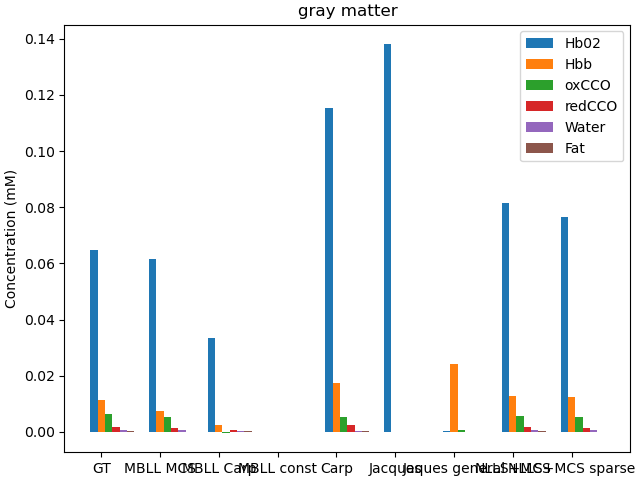

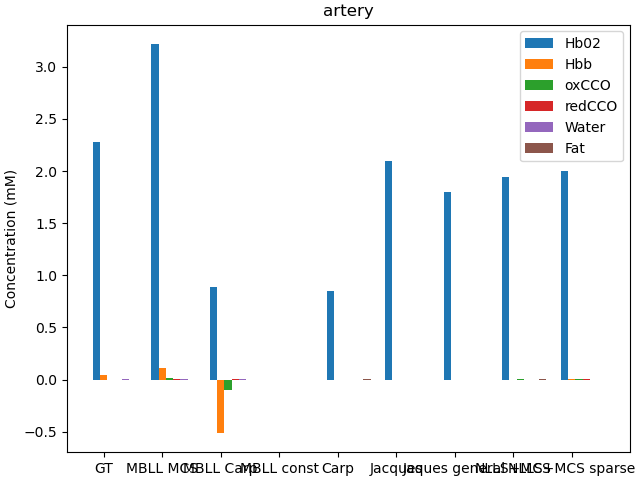

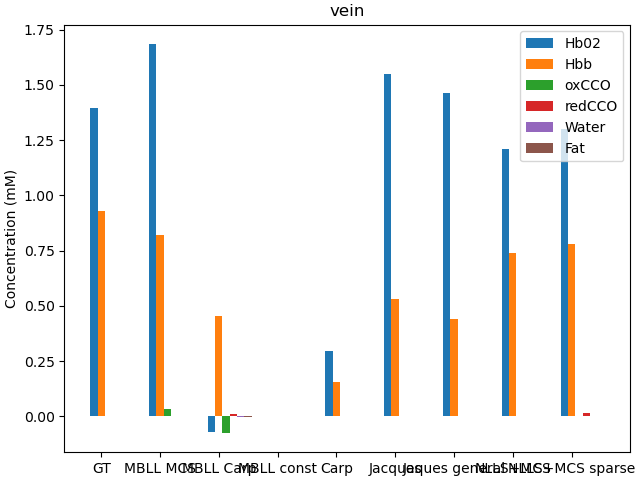

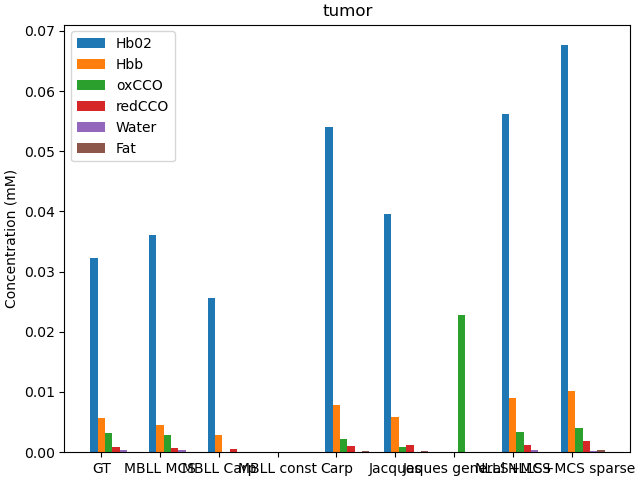

In [33]:
# append GT concentrations, cut scattering params
plot_data = np.concatenate(
    (
        np.array([simulation_data[tissue][0][:, 0] for tissue in tissue_types])[:, None, :],
        reconstructed_concentrations[:, :, :6, plotted_spectrum_idx]
    ),
axis=1)

plot_data[:, :, -2:] /= 10
plot_data[:, 3, :] = 0

plot_concentrations_bar(
    plot_data, 
    tissue_types,
    ["GT", "MBLL MCS", "MBLL Carp", "MBLL const", "Carp", "Jacques", "Jaques general", "NLLS+MCS", "NLLS+MCS sparse"],
    ["Hb02", "Hbb", "oxCCO", "redCCO", "Water", "Fat"]
)

In [34]:
# models, tissue, spectrum
squared_concentration_error = np.empty((len(backward_models_mbll) + len(backward_models_nonlinear), 4, simulation_data["tumor"][-1].shape[1]))
# models, tissue + 1
squared_concentration_error_total_avg = np.empty((len(backward_models_mbll) + len(backward_models_nonlinear), 5))

# t, m, p, s for reconstructed_concentrations
for tissue_idx, tissue in enumerate(tissue_types):
    squared_concentration_error[:, tissue_idx, :] = np.sqrt(np.sum((reconstructed_concentrations[tissue_idx, :, :, :] - simulation_data[tissue][0][None, :, :])**2, axis=1))
    squared_concentration_error_total_avg[:, tissue_idx] = np.average(squared_concentration_error[:, tissue_idx, :], axis=-1)

squared_concentration_error_total_avg[:, 4] = np.average(squared_concentration_error_total_avg[:, :4], axis=-1)

In [35]:
df = pandas.DataFrame(squared_concentration_error_total_avg)
df.index = ["MBLL MCS", "MBLL Carp", "MBLL const."] + list(backward_models_nonlinear.keys())
df.columns = ["gray matter", "artery", "vein", "tumor", "average"]
print(df)

                         gray matter     artery      vein     tumor    average
MBLL MCS                    0.179755   7.426843  3.312009  0.162347   2.770238
MBLL Carp                   0.784855   9.981308  5.929602  0.411768   4.276883
MBLL const.                 4.289977  30.265695  4.935125  3.431877  10.730668
Carp                        0.348377   2.010935  1.536695  0.243158   1.034791
Jacques tissue specific     0.734762   0.570922  0.643648  0.267703   0.554259
Jacques general             0.734404   0.671183  0.617547  0.374661   0.599449
NLLS+MCS                    0.123144   0.814949  0.568213  0.147182   0.413372
NLLS+MCS, sparse            0.308821   0.485162  0.792262  0.288193   0.468610


In [36]:
num_models = len(backward_models_mbll) + len(backward_models_nonlinear)
scatter_table_data = np.empty((num_models + 1, 8)) #8 = 2 (a,b) * 4 (tissues)
for tissue_idx, tissue in enumerate(tissue_types):
    scatter_table_data[0, tissue_idx*2] = simulation_data[tissue][1][0, 1]
    scatter_table_data[0, tissue_idx*2 + 1] = simulation_data[tissue][1][1, 1]
    scatter_table_data[1:, (tissue_idx*2):(tissue_idx*2+2)] = reconstructed_scattering_params[tissue_idx, :, :, 1]

df = pandas.DataFrame(scatter_table_data)
df.index = ["GT", "MBLL MCS", "MBLL Carp", "MBLL const."] + list(backward_models_nonlinear.keys())
df.columns = ["GM a", "GM b ", "artery a", "artery b ", "vein a", "vein b", "tumor a ", "tumor b"]
print(df)

                              GM a         GM b    artery a     artery b   \
GT                       45.800000  3.239000e+00  27.000000  8.100000e-01   
MBLL MCS                 25.478647           NaN  35.619301           NaN   
MBLL Carp                -0.002133           NaN  -0.201880           NaN   
MBLL const.              40.494026           NaN  21.963617           NaN   
Carp                     46.691922  3.304547e+00   6.976755  4.291404e-01   
Jacques tissue specific  99.047550  1.101164e-12  28.386401  1.390926e-22   
Jacques general          75.906754  5.855031e+00  36.793642  1.408149e-15   
NLLS+MCS                 40.515806  3.239742e+00  20.967014  7.519044e-01   
NLLS+MCS, sparse         38.281182  3.245602e+00  21.494201  7.614031e-01   

                            vein a        vein b   tumor a    tumor b  
GT                       27.000000  8.100000e-01  38.600000  1.862000  
MBLL MCS                 27.849720           NaN  16.700995       NaN  
MBLL Carp    